In [1]:
import OpenPNM as op
import scipy as sp
print(op.__version__)
%matplotlib inline

1.6.2


## Generate Two Networks with Different Spacing

In [2]:
spacing_lg = 0.00006
layer_lg = op.Network.Cubic(shape=[10, 10, 1], spacing=spacing_lg)

In [3]:
spacing_sm = 0.00002
layer_sm = op.Network.Cubic(shape=[30, 5, 1], spacing=spacing_sm)

## Position Networks Appropriately, then Stitch Together

In [4]:
# Start by assigning labels to each network for identification later
layer_sm['pore.small'] = True
layer_sm['throat.small'] = True
layer_lg['pore.large'] = True
layer_lg['throat.large'] = True
# Next manually offset CL one full thickness relative to the GDL
layer_sm['pore.coords'] -= [0, spacing_sm*5, 0]
layer_sm['pore.coords'] += [0, 0, spacing_lg/2 - spacing_sm/2]  # And shift up by 1/2 a lattice spacing
# Finally, send both networks to stitch which will stitch CL onto GDL
op.Utilities.topology.stitch(network=layer_lg, donor=layer_sm, 
                             P_network=layer_lg.pores('bottom'), 
                             P_donor=layer_sm.pores('top'), 
                             len_max=0.00005)
combo_net = layer_lg
combo_net.name = 'combo'

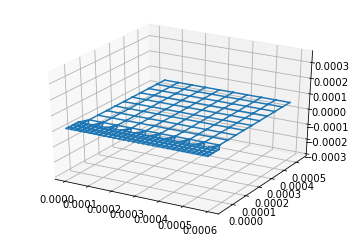

In [5]:
fig = op.Network.tools.plot_connections(combo_net)

## Create Geometry Objects for Each Layer

In [6]:
Ps = combo_net.pores('small')
Ts = combo_net.throats('small')
geom_sm = op.Geometry.GenericGeometry(network=combo_net, pores=Ps, throats=Ts)
Ps = combo_net.pores('large')
Ts = combo_net.throats('small', mode='not')
geom_lg = op.Geometry.GenericGeometry(network=combo_net, pores=Ps, throats=Ts)

### Add Geometrical Properties to the *Small* Domain
The *small* domain will be treated as a continua, so instead of assigning pore sizes we want the 'pore' to be same size as the lattice cell. 

In [7]:
geom_sm['pore.diameter'] = spacing_sm
geom_sm['pore.area'] = spacing_sm**2
geom_sm['throat.diameter'] = spacing_sm
geom_sm['throat.area'] = spacing_sm**2
geom_sm['throat.length'] = 1e-12  # A very small number to represent nearly 0-length

### Add Geometrical Properties to the *Large* Domain

In [8]:
geom_lg['pore.diameter'] = spacing_lg*sp.rand(combo_net.num_pores('large'))
geom_lg.add_model(propname='pore.area',
                  model=op.Geometry.models.pore_area.spherical)
geom_lg.add_model(propname='throat.diameter',
                  model=op.Geometry.models.throat_diameter.minpore)
geom_lg.add_model(propname='throat.area',
                  model=op.Geometry.models.throat_area.cylinder)
geom_lg.add_model(propname='throat.length',
                  model=op.Geometry.models.throat_length.straight)

## Create Phase and Physics Objects

In [9]:
air = op.Phases.Air(network=combo_net, name='air')
phys_lg = op.Physics.GenericPhysics(network=combo_net, geometry=geom_lg, phase=air)
phys_sm = op.Physics.GenericPhysics(network=combo_net, geometry=geom_sm, phase=air)

Add pore-scale models for diffusion to each Physics:

In [10]:
phys_lg.add_model(propname='throat.diffusive_conductance',
                  model=op.Physics.models.diffusive_conductance.bulk_diffusion)
phys_sm.add_model(propname='throat.diffusive_conductance',
                  model=op.Physics.models.diffusive_conductance.bulk_diffusion)

For the *small* layer we've used a normal diffusive conductance model, which when combined with the diffusion coefficient of air will be equivalent to open-air diffusion.  If we want the *small* layer to have some tortuosity we must account for this:

In [11]:
porosity = 0.5
tortuosity = 2
phys_sm['throat.diffusive_conductance'] *= (porosity/tortuosity)

Note that this extra line is NOT a pore-scale model, so it will be over-written when the `phys_sm` object is regenerated.

### Add a Reaction Term to the Small Layer
A standard n-th order chemical reaction is $ r=k \cdot x^b $, or more generally: $ r = A_1 \cdot x^{A_2} + A_3 $.  This model is available in `OpenPNM.Physics.models.generic_source_terms`, and we must specify values for each of the constants.

In [12]:
# Set 
phys_sm['pore.A1'] = -1e-10  # Reaction pre-factor
phys_sm['pore.A2'] = 2  # Reaction order
phys_sm['pore.A3'] = 0  # A generic offset that is not needed so set to 0
phys_sm.add_model(propname='pore.reaction',
                  model=op.Physics.models.generic_source_term.power_law,
                  A1='pore.A1', A2='pore.A2', A3='pore.A3',
                  x='pore.mole_fraction', 
                  regen_mode='deferred')

## Perform a Diffusion Calculation

In [13]:
Deff = op.Algorithms.FickianDiffusion(network=combo_net, phase=air)
Ps = combo_net.pores(['large', 'right'], mode='intersection')
Deff.set_boundary_conditions(pores=Ps, bcvalue=1, bctype='Dirichlet')
Ps = combo_net.pores('small')
Deff.set_source_term(source_name='pore.reaction', pores=Ps)
Deff.run()

## Visualize the Concentration Distribution

Save the results to a VTK file for visualization in Paraview:

In [14]:
Deff.return_results()
op.Utilities.IO.VTK.save(network=combo_net, phases=[air])

2018-02-18 23:14:27,474 | WARNING  | root._interleave_data | 'pore.A1' not found on at least one object
2018-02-18 23:14:27,477 | WARNING  | root._interleave_data | 'pore.A2' not found on at least one object
2018-02-18 23:14:27,478 | WARNING  | root._interleave_data | 'pore.A3' not found on at least one object


And the result would look something like this:

![](https://i.imgur.com/otsd6iX.png)